In [144]:
import json
import re
import os
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer

#necessary data from collections
with open('../Data Collection/gov_id_industry.json', 'r') as f:
    new_info=json.load(f)

In [145]:
# preprocessing steps, remove stopwords, lowercase, remove nonalphabet chars, stem remaining words
stem=PorterStemmer()
stopwords = set(stopwords.words('english'))
cleaner = lambda sentence: set(re.sub(r'[^a-zA-Z ]',' ',sentence.lower()).split()) - stopwords
term_to_industry={}

# determine if a bill is relevant to an industry depending on industry terms
for id, info in new_info.items():
    for i in info:
        for term in cleaner(i['industry_name']):
            term=stem.stem(term)
            if not term_to_industry.get(term):
                term_to_industry[term]=set([i['industry_name']])
            else:
                term_to_industry[term].add(i['industry_name'])

In [146]:
# load in all bills scraped
bill_id=set()
bills=[]
for file in os.listdir('../Data Collection/votes'):
    with open(f'../Data Collection/votes/{file}') as f:
        for z in json.load(f):
            if z[0] not in bill_id:
                bill_id.add(z[0])
                bills.append(z)

In [147]:
bills

[['HR2882',
  'Further Consolidated Appropriations Act, 2024',
  'Economics and Public Finance',
  "<p><b>Udall Foundation Reauthorization Act of 2023</b></p> <p>This bill reauthorizes through FY2028 the Morris K. Udall and Stewart L. Udall Foundation, its Environmental Dispute Resolution Fund, and the foundation's support for training of health care and public policy professionals through the Native Nations Institute. The foundation, an independent executive branch agency, works to strengthen (1) the stewardship of the environment, public lands, and natural resources; and (2) Native Nations to facilitate their self-determination, governance, and human capital goals.</p>",
  {},
  {'S354': 'Yea',
   'S317': 'Nay',
   'S330': 'Nay',
   'S396': 'Nay',
   'S341': 'Yea',
   'S370': 'Yea',
   'S343': 'Yea',
   'S397': 'Not Voting',
   'S416': 'Yea',
   'S307': 'Yea',
   'S417': 'Nay',
   'S424': 'Yea',
   'S275': 'Yea',
   'S372': 'Yea',
   'S308': 'Yea',
   'S277': 'Yea',
   'S309': 'Yea',

In [148]:
term_to_industry

{'retir': {'Retired'},
 'estat': {'Real Estate'},
 'real': {'Real Estate'},
 'leadership': {'Leadership PACs'},
 'pac': {'Leadership PACs'},
 'casino': {'Casinos/Gambling'},
 'gambl': {'Casinos/Gambling'},
 'misc': {'Misc Defense',
  'Misc Finance',
  'Misc Issues',
  'Misc Manufacturing &amp; Distributing',
  'Misc Transport',
  'Misc Unions'},
 'defens': {'Defense Aerospace', 'Defense Electronics', 'Misc Defense'},
 'amp': {'Beer, Wine &amp; Liquor',
  'Building Materials &amp; Equipment',
  'Crop Production &amp; Basic Processing',
  'Electronics Mfg &amp; Equip',
  'Fisheries &amp; Wildlife',
  'Food &amp; Beverage',
  'Food Processing &amp; Sales',
  'Forestry &amp; Forest Products',
  'Misc Manufacturing &amp; Distributing',
  'Oil &amp; Gas',
  'Poultry &amp; Eggs',
  'Securities &amp; Investment'},
 'product': {'Agricultural Services/Products',
  'Crop Production &amp; Basic Processing',
  'Forestry &amp; Forest Products',
  'Pharmaceuticals/Health Products'},
 'process': {'Cro

In [149]:
#score, total tuple for each industry
lobbying_scores={id:{i['industry_name']:[0,0] for i in info} for id, info in new_info.items()}
#vader
sid = SentimentIntensityAnalyzer()
neg_votes=set(['Nay','No'])
pos_votes=set(['Aye','Yea'])

for bill in bills:
    #determine sentiment
    sentence=tokenize.sent_tokenize(bill[3])[0]
    ss = sid.polarity_scores(sentence)
    #1 for positive, 0 for negative
    max_sentiment=-1
    if ss['pos']>ss['neg']:max_sentiment=1

    #bill terms
    votes=bill[-1] if bill[-1] else bill[-2]
    relevant_terms={stem.stem(t) for t in cleaner(bill[1])}
    
    #candidate loop
    for id, info in new_info.items():
        #candidate industries:
        relevant_industries=set()
        relevant_industries.update(sum([list(cleaner(i['industry_name'])) for i in info],[]))
        relevant_industries = {stem.stem(t) for t in relevant_industries}
        #relevant?:
        if relevant_terms & relevant_industries:
            #scores move in intervals of 1
            cast=votes.get(id)
            if cast in pos_votes:adjust=1*max_sentiment
            elif cast in neg_votes:adjust=-1*max_sentiment
            for term in relevant_terms & relevant_industries:
                for industry in term_to_industry[term]:
                    if lobbying_scores[id].get(industry):
                        lobbying_scores[id][industry][0]+=max(adjust,0) #-1 -> 0
                        lobbying_scores[id][industry][1]+=1 #total        

In [150]:
lobbying_scores

{'C001054': {'Retired': [2, 2],
  'Real Estate': [0, 0],
  'Leadership PACs': [2, 3],
  'Casinos/Gambling': [0, 0],
  'Misc Defense': [7, 8],
  'Crop Production &amp; Basic Processing': [2, 2],
  'Lawyers/Law Firms': [2, 5],
  'Lobbyists': [0, 0],
  'Building Materials &amp; Equipment': [13, 19],
  'Insurance': [0, 0]},
 'M001212': {'Crop Production &amp; Basic Processing': [2, 2],
  'Retired': [2, 2],
  'Real Estate': [0, 0],
  'Leadership PACs': [2, 3],
  'Republican/Conservative': [1, 1],
  'Building Materials &amp; Equipment': [12, 19],
  'General Contractors': [2, 3],
  'Misc Defense': [6, 8],
  'Health Professionals': [9, 21],
  'Agricultural Services/Products': [27, 34]},
 'R000575': {'Misc Defense': [7, 8],
  'Defense Aerospace': [7, 8],
  'Lobbyists': [0, 0],
  'Leadership PACs': [2, 3],
  'Defense Electronics': [8, 9],
  'Lawyers/Law Firms': [3, 5],
  'Real Estate': [0, 0],
  'Crop Production &amp; Basic Processing': [2, 2],
  'Insurance': [0, 0],
  'General Contractors': [1,

In [151]:
with open('./raw_lobbying_scores.json', 'w') as f:
    json.dump(lobbying_scores,f)

In [152]:
##Beter scoring algorithm
final_scores_and_info={}
total_lobbying_donations={c_id:sum([int(i['total']) for i in val]) for c_id,val in new_info.items()}
# some extra variables for holding interesting information.
# modified presence controls final weighting in the case where a congressman had no relevant votes for
# an industry.
# generally, the form is:
# votes aligned w. industry/votes in industry * industry lobbying fund / total adjusted funding
for c_id, raw_scores in lobbying_scores.items():
    running_total=0
    modified_presence=0
    best_rate=[10e-4,None]
    top_industry_info=[None,None,None]
    for lobby_info,(industry,voting) in zip(new_info[c_id],raw_scores.items()):
        if not voting[0]:
            modified_presence+=int(lobby_info['total'])
        else:
            if not top_industry_info[1]:
                top_industry_info=[industry, int(lobby_info['total']), voting[0]/voting[1]]
            running_total+=((voting[0]/voting[1])*(int(lobby_info['total'])))
            if voting[0]/voting[1] > best_rate[0]:
                best_rate=[voting[0]/voting[1],industry]

    final_scores_and_info[c_id]={
        'Lobbying score': running_total/(total_lobbying_donations[c_id]-modified_presence),
        'Highest paying industry info': {'industry': top_industry_info[0], 'donations': top_industry_info[1], 'score:':top_industry_info[2]},
        'Most loyal industry': {'industry': best_rate[1], 'score': best_rate[0]}
    }

In [153]:
import requests
import time
import random
# Names were dropped from ids at an earlier phase, easiest to restore through requests on bioguide id.
cong_key='Jq9Uy2kgbNouvTJfoixzEYYQQJ88FAjM3D5HFPne'
#add names to ids
for c_id in final_scores_and_info.keys():
    resp=requests.get(f'https://api.congress.gov/v3/member/{c_id}?api_key={cong_key}')
    final_scores_and_info[c_id]['Name']=resp.json()['member']['directOrderName']
    time.sleep(random.random()*2)

In [154]:
for info in final_scores_and_info.values():
    print(info['Name'],info['Lobbying score'])

Jerry L. Carl 0.8143216832502334
Barry Moore 0.8298510634233924
Mike Rogers 0.7952644416681539
Robert B. Aderholt 0.8493270248404857
Dale W. Strong 0.7273639986041822
Gary J. Palmer 0.7206818882613022
Terri A. Sewell 0.6393150701380168
Tommy Tuberville 0.8759365603899685
Dan Sullivan 0.774629866590477
Lisa Murkowski 0.7455187940393098
David Schweikert 0.7435413072413171
Ruben Gallego 0.8251868563391312
Greg Stanton 0.7612667732870685
Andy Biggs 0.5011373685619088
Juan Ciscomani 0.5053089096439459
Debbie Lesko 0.7303596456571338
Paul A. Gosar 0.898145275167218
Mark Kelly 0.8565864418619867
Kyrsten Sinema 0.6706417065390097
Steve Womack 0.8372311705655234
Bruce Westerman 0.6905412822556821
Tom Cotton 0.8481043515406587
John Boozman 0.7718537514699328
Doug LaMalfa 0.9089987633869497
Jared Huffman 0.7898921899894719
Kevin Kiley 0.88752491892354
Mike Thompson 0.7500568993766986
Tom McClintock 0.4770541099388308
Ami Bera 0.6913494035608919
Doris O. Matsui 0.7593298297281361
John Garamendi 0.

In [155]:
with open('./final_scoring_info.json', 'w') as f:
    json.dump(final_scores_and_info,f)

In [156]:
# all rates of all lobbying industries
rates=[]
for c_id, raw_scores in lobbying_scores.items():
    for lobby_info,(industry,voting) in zip(new_info[c_id],raw_scores.items()):
        if voting[0]:
            rates.append([int(lobby_info['total']),voting[0]/voting[1]])

In [157]:
# sort rates and seperate in bars of 5%. Should provide insight if industries that lobby more money
# end up recieving higher 'aligned voting' rates, regardless of what that industry actually is
import numpy as np
sorted_rates=np.array(sorted(rates))
bounds=np.linspace(0,len(ttt),21).astype(int)
avg_bribe=[]
avg_rate=[]
for i in range(20):
    avg_bribe.append((sorted_rates[bounds[i]:bounds[i+1]][:,0]).mean())
    avg_rate.append((sorted_rates[bounds[i]:bounds[i+1]][:,1]).mean())

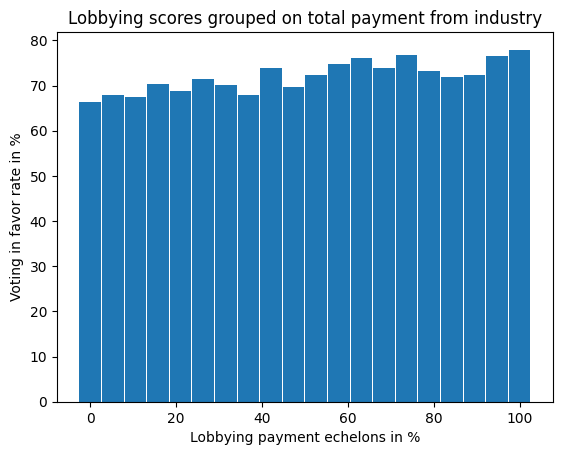

In [158]:
plt.bar(x=np.linspace(0,100,20),height=np.array(avg_rate)*100, width=5)
plt.xlabel('Lobbying payment echelons in %')
plt.ylabel('Voting in favor rate in %')
plt.title('Lobbying scores grouped on total payment from industry')
plt.savefig('./vis.png')
plt.show()